# Mask Detection – Preprocessing, Split (8-1-1) and Training with MobileNetV2

## 1. Import libraries

In [46]:

import os
import random
import shutil
import zipfile
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras import layers, models


## 2. Unzip dataset

## 3. Function to show sample images

In [47]:

def show_samples(data_dir, classes=("with_mask", "without_mask"), num_images=3):
    plt.figure(figsize=(12, 6))
    idx = 1

    for cls in classes:
        cls_dir = os.path.join(data_dir, cls)
        images = [
            f for f in os.listdir(cls_dir)
            if f.lower().endswith((".jpg", ".png", ".jpeg"))
        ][:num_images]

        for img_name in images:
            img = Image.open(os.path.join(cls_dir, img_name)).convert("RGB")
            plt.subplot(len(classes), num_images, idx)
            plt.imshow(img)
            plt.title(cls)
            plt.axis("off")
            idx += 1

    plt.show()


## 4. Show images after unzip

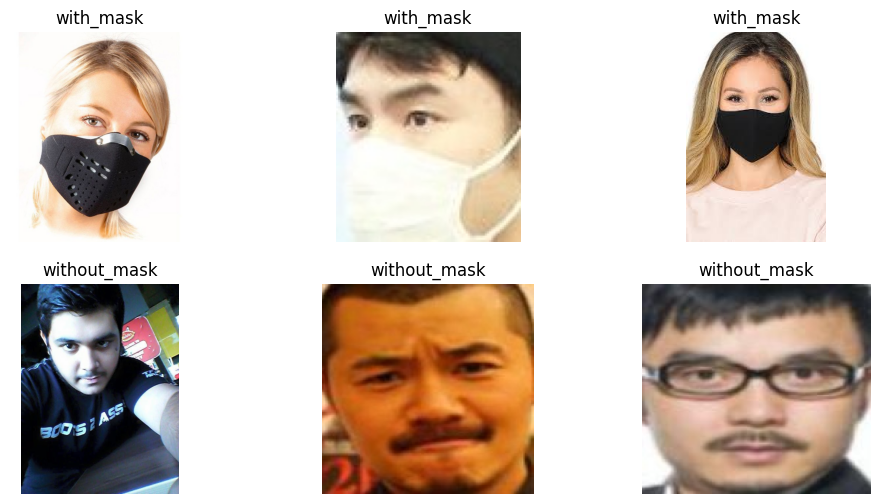

In [48]:

raw_data_dir = "./data"
show_samples(raw_data_dir)


## 5. Split data (8-1-1)

In [49]:

input_dir = "./data"
output_dir = "./split_data"

if os.path.exists(output_dir):
    shutil.rmtree(output_dir)

os.makedirs(output_dir, exist_ok=True)

splits = {"train": 0.8, "val": 0.1, "test": 0.1}

for cls in os.listdir(input_dir):
    cls_path = os.path.join(input_dir, cls)
    images = [
        f for f in os.listdir(cls_path)
        if f.lower().endswith((".jpg", ".png", ".jpeg"))
    ]
    random.shuffle(images)

    n_total = len(images)
    n_train = int(n_total * splits["train"])
    n_val = int(n_total * splits["val"])

    split_dict = {
        "train": images[:n_train],
        "val": images[n_train:n_train + n_val],
        "test": images[n_train + n_val:]
    }

    for split, split_images in split_dict.items():
        split_cls_dir = os.path.join(output_dir, split, cls)
        os.makedirs(split_cls_dir, exist_ok=True)

        for img in split_images:
            shutil.copy(
                os.path.join(cls_path, img),
                os.path.join(split_cls_dir, img)
            )


## 6. Show images after split (train set)

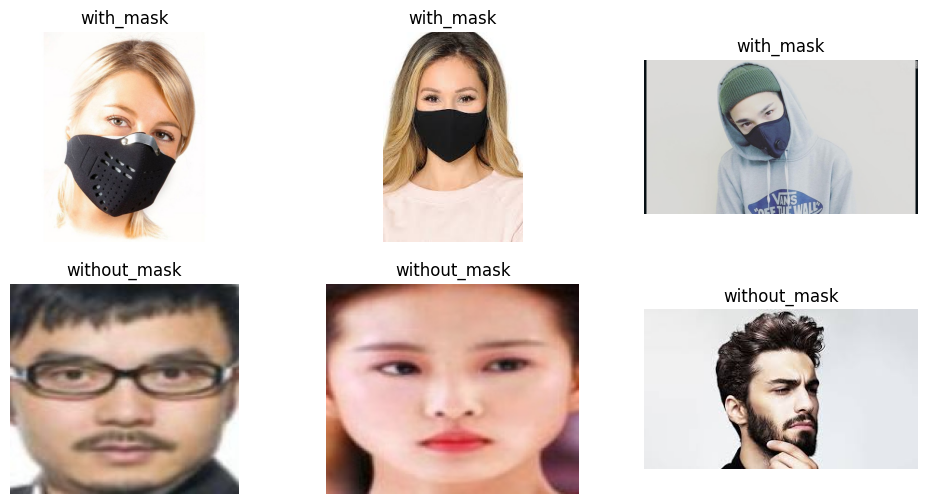

In [50]:

show_samples("./split_data/train")


## 7.  preprocessing

In [ ]:
import os
import cv2
import numpy as np
from PIL import Image
import hashlib
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

input_dir = "split_data"
processed_dir = "pre_train"
size = (224, 224)

os.makedirs(processed_dir, exist_ok=True)

# Load OpenCV DNN face detector
net = cv2.dnn.readNetFromCaffe(
    "models/deploy.prototxt",
    "models/res10_300x300_ssd_iter_140000.caffemodel"
)

hashes = set()

def is_duplicate(img_array):
    h = hashlib.md5(img_array.tobytes()).hexdigest()
    if h in hashes:
        return True
    hashes.add(h)
    return False


for root, dirs, files in os.walk(input_dir):
    # giữ nguyên cấu trúc thư mục
    relative_path = os.path.relpath(root, input_dir)
    output_root = os.path.join(processed_dir, relative_path)
    os.makedirs(output_root, exist_ok=True)

    for file in files:
        if not file.lower().endswith(('.jpg', '.png', '.jpeg')):
            continue

        img_path = os.path.join(root, file)

        frame = cv2.imread(img_path)
        if frame is None:
            continue

        h, w = frame.shape[:2]

        blob = cv2.dnn.blobFromImage(
            cv2.resize(frame, (300, 300)),
            1.0,
            (300, 300),
            (104.0, 177.0, 123.0)
        )

        net.setInput(blob)
        detections = net.forward()

        for i in range(detections.shape[2]):
            conf = detections[0, 0, i, 2]
            if conf < 0.6:
                continue

            box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
            x1, y1, x2, y2 = box.astype("int")

            # clamp bounding box
            x1, y1 = max(0, x1), max(0, y1)
            x2, y2 = min(w, x2), min(h, y2)

            face = frame[y1:y2, x1:x2]
            if face.size == 0:
                continue

            face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
            face = cv2.resize(face, size)

            img_array = np.array(face).astype("float32")

            if is_duplicate(img_array):
                break

            img_array = preprocess_input(img_array)

            img_save = Image.fromarray(
                ((img_array + 1) / 2 * 255).astype("uint8")
            )

            img_save.save(os.path.join(output_root, file))
            break  # chỉ lấy 1 khuôn mặt


## 8. Show after preprocess

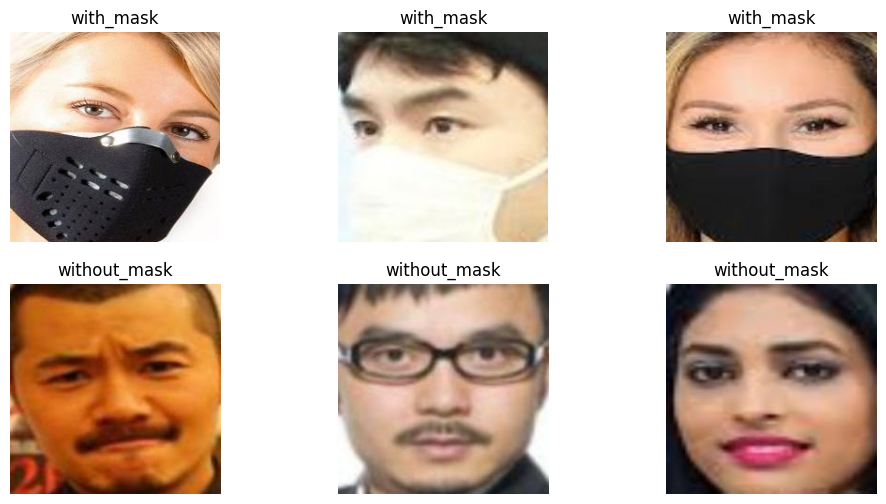

In [52]:
classes = ("with_mask", "without_mask")
num_images = 3
plt.figure(figsize=(12, 6))
idx = 1

for cls in classes:
    cls_dir = os.path.join(processed_dir, cls)
    images = [
        f for f in os.listdir(cls_dir)
        if f.lower().endswith((".jpg", ".png", ".jpeg"))
    ][:num_images]

    for img_name in images:
        img = Image.open(os.path.join(cls_dir, img_name)).convert("RGB")
        img = np.array(img).astype("float32") / 255.0
        plt.subplot(len(classes), num_images, idx)
        plt.imshow(img)
        plt.title(cls)
        plt.axis("off")
        idx += 1

plt.show()

## 9. Load data for MobileNetV2

In [53]:

train_dir = "./pre_train/train"
val_dir = "./pre_train/val"
test_dir = "./pre_train/test"

datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_gen = datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode="binary"
)

val_gen = datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode="binary"
)

test_gen = datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode="binary",
    shuffle=False
)


Found 0 images belonging to 0 classes.
Found 0 images belonging to 0 classes.
Found 0 images belonging to 0 classes.
Found 0 images belonging to 0 classes.
Found 0 images belonging to 0 classes.


## 10. Build MobileNetV2 model

In [54]:

base_model = MobileNetV2(
    weights="imagenet",
    include_top=False,
    input_shape=(224, 224, 3)
)

base_model.trainable = False

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation="relu"),
    layers.Dense(1, activation="sigmoid")
])

model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)


## 11. Train model

In [55]:

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10
)


ValueError: The PyDataset has length 0

## 12. Evaluate on test set and save

In [ ]:

model.evaluate(test_gen)
model.save("mask_mobilenet.h5")



24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 244ms/step - accuracy: 0.9894 - loss: 0.0527
24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 244ms/step - accuracy: 0.9894 - loss: 0.0527
